# Walk-through of a simple solution to Kaggle's 'Forest Cover Type Prediction' competition

## 1. Examine the data

In [27]:
import pandas as pd
pd.set_option('display.max_rows',20)
pd.set_option('display.max_columns',10)

Read in the data as pandas dataframes. Data was downloaded as csv files from the [Kaggle competition Data page](http://www.kaggle.com/c/forest-cover-type-prediction/data).

In [28]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

Let's take a look at what features we have.

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15120 entries, 0 to 15119
Data columns (total 56 columns):
Id                                    15120 non-null int64
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_T

We can see that 'Soil_Type' and 'Wilderness_Area' have already been one-hot encoded, so we don't need to preprocess the categorical variables.

The 'Ids' column will not be required as a feature, so let's drop it from the train dataframe. We'll need to know the 'Ids' of the test data when submitting our predicitions, so make a copy then drop.

In [30]:
train=train.drop('Id',axis=1)

ids=test['Id']
test=test.drop('Id',axis=1)    

Seperate training data into features (xtrain) and targets (y).

In [31]:
y=train['Cover_Type']
xtrain=train.drop('Cover_Type',axis=1)

The first 10 features are the only non-categorical ones. Let's examine these more closely.

In [32]:
train.ix[:,:5].describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,2749.322553,156.676653,16.501587,227.195701,51.076521
std,417.678187,110.085801,8.453927,210.075296,61.239406
min,1863.000000,0.000000,0.000000,0.000000,-146.000000
25%,2376.000000,65.000000,10.000000,67.000000,5.000000
50%,2752.000000,126.000000,15.000000,180.000000,32.000000
75%,3104.000000,261.000000,22.000000,330.000000,79.000000
max,3849.000000,360.000000,52.000000,1343.000000,554.000000


In [33]:
train.ix[:,5:10].describe()

,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,1714.023214,212.704299,218.965608,135.091997,1511.147288
std,1325.066358,30.561287,22.801966,45.895189,1099.936493
min,0.000000,0.000000,99.000000,0.000000,0.000000
25%,764.000000,196.000000,207.000000,106.000000,730.000000
50%,1316.000000,220.000000,223.000000,138.000000,1256.000000
75%,2270.000000,235.000000,235.000000,167.000000,1988.250000
max,6890.000000,254.000000,254.000000,248.000000,6993.000000


It's clear we'll need to scale these non-catgeorical features if we want to use Support Vector Machines/linear models.

## 2. Feature Scaling

Let's use StandardScaler from sklearn. We can fit it to the training data and then use it to transform both the training and test data in exactly the same way.

In [34]:
from sklearn import preprocessing

colToScale=['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology', 
             'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 
             'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
             'Horizontal_Distance_To_Fire_Points']
    
xtrain_scale=xtrain.copy()
test_scale=test.copy()

for col in colToScale:
    scaler = preprocessing.StandardScaler().fit(train[col].values.astype('float_'))
    xtrain_scale[col] = scaler.transform(xtrain[col].values.astype('float_'))
    test_scale[col] = scaler.transform(test[col].values.astype('float_'))

ValueError: Expected 2D array, got 1D array instead:
array=[2596. 2590. 2804. ... 2492. 2487. 2475.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Display the properties of some of the transformed features to confirm they now have mean=0 and std=1.

In [21]:
xtrain_scale.ix[:,5:10].describe()

,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,1714.023214,212.704299,218.965608,135.091997,1511.147288
std,1325.066358,30.561287,22.801966,45.895189,1099.936493
min,0.000000,0.000000,99.000000,0.000000,0.000000
25%,764.000000,196.000000,207.000000,106.000000,730.000000
50%,1316.000000,220.000000,223.000000,138.000000,1256.000000
75%,2270.000000,235.000000,235.000000,167.000000,1988.250000
max,6890.000000,254.000000,254.000000,248.000000,6993.000000


## 3. Try out a few classifiers

Since we have $\approx$ 15K samples of labeled data, which we are trying to categorise lets try LinearSVC, then KNeighborsClassifier, then Ensemble Classifiers (following the suggestions of the [sklearn cheat sheet](http://scikit-learn.org/stable/tutorial/machine_learning_map/)).

### a) Support Vector Machine (LinearSVC)

Train a LinearSVC estimator using the scaled dataframe, xtrain_scale and print out the number of samples assigned to each 'Cover_Type' catgeory (1 to 7).

In [22]:
from sklearn.svm import LinearSVC
from sklearn import cross_validation

clf_lsvc=LinearSVC(dual=False)
clf_lsvc.fit(xtrain_scale,y)

ypred_lsvc=clf_lsvc.predict(test_scale)

print pd.Series(ypred_lsvc).value_counts(sort=False)

SyntaxError: invalid syntax (<ipython-input-22-af83a556cda3>, line 9)

We can use cross-validation to estimate the accuracy of this classifier.

In [23]:
cross_validation.cross_val_score(clf_lsvc,xtrain_scale,y).mean()

NameError: name 'cross_validation' is not defined

### b) K Nearest Neighbors (kNeighborsClassifier)

Train a KNeighborsClassifier model using the scaled dataframe, xtrain_scale.

In [24]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn=KNeighborsClassifier()
clf_knn.fit(xtrain_scale,y)

ypred_knn=clf_knn.predict(test_scale)

print pd.Series(ypred_knn).value_counts(sort=False)

SyntaxError: invalid syntax (<ipython-input-24-1ad13e0925c4>, line 8)

In [25]:
cross_validation.cross_val_score(clf_knn,xtrain_scale,y).mean()

NameError: name 'cross_validation' is not defined

### c) Ensemble classifier (RandomForestClassifier)

We don't need to scale the data for use with random forests, so use the original dataframes.

In [14]:
from sklearn.ensemble import RandomForestClassifier

clf_rf=RandomForestClassifier(random_state=0)
clf_rf.fit(xtrain,y)

ypred_rf=clf_rf.predict(test)

print pd.Series(ypred_rf).value_counts(sort=False)

1    226247
2    211511
3     37522
4      2752
5     32953
6     23763
7     31144
dtype: int64


In [15]:
cross_validation.cross_val_score(clf_rf,xtrain,y).mean()

0.74629629629629635

### d) Conclusion

From our cross-validation estimates it seems that RandomForestClassifier is the most accurate (with default parameters), so let's continue to work with that. First let's write the predicitions for the test data to file so we can upload to Kaggle for assessment.

In [16]:
pd.DataFrame({'Id':ids,'Cover_Type':ypred_rf},
            columns=['Id','Cover_Type']).to_csv('submission_rf.csv',index=False)

## 4. Optimise the hyperparameters of the chosen classifier

The most important parameters for RandomForestClassifier are n_estimators (the number of trees) and max_features. 

Max_features='sqrt' is a good option for classification tasks (according to the docs) so we will use that.

In [17]:
clf_rf.set_params(max_features='sqrt')

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
            min_samples_split=2, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0)

More trees is better, but will take longer and improvements will plateau eventually. Lets plot the cross-validation score for different values of n_estimators to help choose the optimal value.

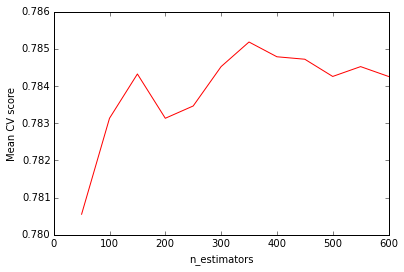

In [18]:
from sklearn.learning_curve import validation_curve

prange=np.arange(50,650,50)
train_scores, cv_scores = validation_curve(clf_rf, xtrain, y,param_name='n_estimators',
                                              param_range=prange)

plt.xlabel('n_estimators')
plt.ylabel('Mean CV score')
plt.plot(prange, np.mean(cv_scores, axis=1), label="Cross-validation score",color="r")

After n_estimators=350 the cross-validation score begins to decrease again, so we will use 350.

Set chosen parameters and fit the model again.

In [20]:
clf_rf.set_params(n_estimators=350)

clf_rf.fit(xtrain,y)

cross_validation.cross_val_score(clf_rf,xtrain,y).mean()

0.78518518518518521

Great! Our estimated accuracy score has improved compared with the RandomForestClassifier with the default parameters.

Write predictions to a csv file so we can submit to Kaggle.

In [21]:
ypred_rf_opt=clf_rf.predict(test)

pd.DataFrame({'Id':ids,'Cover_Type':ypred_rf_opt},
              columns=['Id','Cover_Type']).to_csv('submission_rf_opt.csv',index=False)

## 5. Feature engineering

Let's try to glean extra information from the data by creating new features from existing ones. 

An obvious choice is computing the absolute distance to hydrology from the vertical and horizontal distances.

In [22]:
def feat_eng(df):
    
    #absolute distance to water
    df['Distance_To_Hydrology']=(df['Vertical_Distance_To_Hydrology']**2.0+
                                 df['Horizontal_Distance_To_Hydrology']**2.0)**0.5
    
feat_eng(xtrain)
feat_eng(test)

In [23]:
clf_rf.fit(xtrain,y)

cross_validation.cross_val_score(clf_rf,xtrain,y).mean()

0.78148148148148155

The accuracy is slightly lower than before, but this is only an estimate. Let's look at the top 5 features, as determined by the classifier.

In [24]:
print pd.DataFrame(clf_rf.feature_importances_,index=xtrain.columns).sort([0], ascending=False)[:5]

                                           0
Elevation                           0.222065
Horizontal_Distance_To_Roadways     0.089462
Horizontal_Distance_To_Fire_Points  0.068934
Distance_To_Hydrology               0.053865
Hillshade_9am                       0.048557


The new feature is in the top 5 so this looks promising. 

Let's see if the value of n_estimators is still optimal with the new feature.

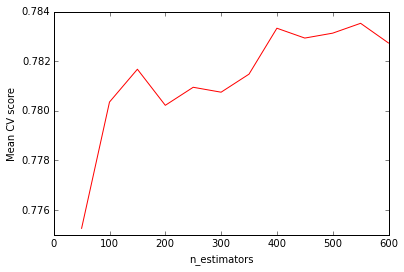

In [25]:
prange=np.arange(50,650,50)
train_scores, cv_scores = validation_curve(clf_rf, xtrain, y,param_name='n_estimators',
                                              param_range=prange)

plt.xlabel('n_estimators')
plt.ylabel('Mean CV score')
plt.plot(prange, np.mean(cv_scores, axis=1), label="Cross-validation score",color="r")

n_estimators=400 is a better choice for the new feature set, so we will use that.

In [26]:
clf_rf.set_params(n_estimators=400)

clf_rf.fit(xtrain,y)

cross_validation.cross_val_score(clf_rf,xtrain,y).mean()

0.78333333333333333

The cross-validation score is slightly better. Write the predictions to file so we can submit them to Kaggle. 

In [27]:
ypred_rf_opt_fe=clf_rf.predict(test)

pd.DataFrame({'Id':ids,'Cover_Type':ypred_rf_opt_fe},
            columns=['Id','Cover_Type']).to_csv('submission_rf_opt_fe.csv',index=False)

We will submit all 3 random forest models to Kaggle and see how they perform on the test data.

## 6. Evaluation of the models

On submission of the predicitions to Kaggle the scores for the RandomForest models were 0.717 (default parameters), 0.753 (optimised parameters) and 0.751 (new feature added). 

The most accurate model is the RandomForestClassifier with optimised parameters but no engineered features.

## 7. Ideas for future work

* The most important features are the numerical ones and these could potentially be combined in many ways to engineer more features.


* There are many features with very low importance. Applying a feature selection technique to remove the least important features could improve the model. This could be applied in conjunction with adding combinations of exisiting features, as mentioned above, by adding more features first and then performing feature selection.


* Try out other ensemble classifiers such as GradientBoostingClassifier and AdaBoostClassifier.